# Create Models	50	

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [1]:
import pandas as pd
import numpy as ny
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import os 
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,brier_score_loss, precision_score, recall_score,f1_score)
import time

In [2]:
!pip3 install pickle5
import socket
import pickle5 as pickle

is_rohit=socket.gethostname()=='Rohits-MacBook-Pro.local'
is_blake=socket.gethostname()=='BJH-ML-machine'
is_neddy=(is_rohit+is_blake==0)

if(is_rohit):
    with open('~/Documents/yelp_datasets/df_business_eda.pickle', "rb") as f:
      pick_data = pickle.load(f)
      pick_data.to_pickle('~/Documents/yelp_datasets/df_business_eda_proto4.pickle')

    df_business_eda = pd.read_pickle("~/Documents/yelp_datasets/df_business_eda_proto4.pickle")
    
if(is_blake):
    df_business_eda = pd.read_pickle("df_business_eda.pickle")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
df_business_eda.head(2)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,city_state,zip3,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,funny_count,review_count,review_word_count
1,2,5.0,False,False,False,True,False,Scottsdale_AZ,852,NaN,NaN,9.0,4,1,2,4,121.000000
3,0,2.5,False,True,False,False,True,North Las Vegas_NV,890,4.0,NaN,3.0,1,0,0,3,26.666667


In [4]:
categorical_cols=df_business_eda.select_dtypes(include=['object']).columns

df_business_hot=df_business_eda

for col in categorical_cols:
    dummies=pd.get_dummies(df_business_hot[col], dummy_na=True, prefix=col)
    df_business_hot=df_business_hot.\
        drop(col,axis=1).\
    merge(
        dummies,
        how='left',
        left_index=True,
        right_index=True
        )
    
df_business_hot=df_business_hot.fillna(False)
df_business_hot.head(2)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
1,2,5.0,False,False,False,True,False,False,False,9,...,0,0,0,0,0,0,0,0,0,0
3,0,2.5,False,True,False,False,True,4,False,3,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_business_hot["above_average"] = ny.where(df_business_hot["stars"] > 3.5, 0, 1)
y=df_business_hot.rating_category
y2 = df_business_hot["above_average"]
X=df_business_hot.drop(["rating_category", "stars","above_average"], axis=1)
#Scale your data
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
X_scaled.head(2)

,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
0,-0.284181,-1.686292,-0.507601,0.489254,-0.580683,-0.800061,-0.255661,-0.150669,-0.273438,-0.252466,...,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.043309,0.0
1,-0.284181,0.593017,-0.507601,-2.043927,1.722109,3.225868,-0.255661,-0.156851,-0.314588,-0.273815,...,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.043309,0.0


In [6]:
num_cv_iterations = 5
num_instances = len(y)
cv_object = ms.ShuffleSplit(n_splits=num_cv_iterations,
                         random_state=123,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=123, test_size=0.2, train_size=None)


In [7]:
def cv_train(name,model,x,y):
    print(f"====Performing Cross Validation for {name}")
    print(f" Iteration ", end = '')
    iter_num=0
    res=pd.DataFrame()

    for train_indices, test_indices in cv_object.split(x,y):
        t = time.time()
        print(f" {iter_num},", end = '')

        X_train = x.iloc[train_indices]
        y_train = y.iloc[train_indices]

        X_test = x.iloc[test_indices]
        y_test = y.iloc[test_indices]

        model.fit(X_train,y_train)  # train object
        y_hat = model.predict(X_test) # get test set precitions

        conf = mt.confusion_matrix(y_test,y_hat)
        
        row=pd.DataFrame([iter_num],columns=['Iteration'])
        row["accuracy"]=accuracy_score(y_test, y_hat)
        row["precision"]=precision_score(y_test, y_hat, average="macro")
        row["recall"]=recall_score(y_test, y_hat, average="macro")
        row["f1"]=f1_score(y_test, y_hat, average="macro")
        row["average_seconds"]= ny.round(time.time() - t)

        res=res.append(row)
        iter_num+=1
    
    #Summarize CV Results 
    summary=res.drop("Iteration",axis=1).agg("mean").to_frame().T
    summary.insert(0,"model",model)
    summary.insert(0,"name",name)
    print("  Cross-validation complete")

    return(summary)

# Compare Competing Models

In [8]:
#LogisticRegression
log_newton_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='newton-cg' )
log_lbfgs_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='lbfgs' )
log_liblinear_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )
log_sag_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='sag' )
log_saga_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='saga')
#SGDClassifier
log_sgd_model = lm.SGDClassifier(n_jobs=-1, loss="log")
svm_sgd_model = lm.SGDClassifier(n_jobs=-1, loss="hinge")

# Model Advantages	10

Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

In [9]:
#supressing warnings, many of the logistic models complain during fitting
import warnings
warnings.filterwarnings('ignore')

#Run CV on all models and combine results into dataframe
cv_results=cv_train("log_newton",log_newton_model, X_scaled, y2).\
    append(cv_train("log_lbfgs",log_lbfgs_model, X_scaled, y2)).\
    append(cv_train("log_liblinear",log_liblinear_model, X_scaled, y2)).\
    append(cv_train("log_sag",log_sag_model, X_scaled, y2)).\
    append(cv_train("log_saga",log_saga_model, X_scaled, y2)).\
    append(cv_train("log_sgd",log_sgd_model, X_scaled, y2)).\
    append(cv_train("svm_sgd",svm_sgd_model, X_scaled, y2)).\
    sort_values("f1", ascending=False)

cv_results

====Performing Cross Validation for log_newton
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_lbfgs
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_liblinear
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_sag
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_saga
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for svm_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete


,name,model,accuracy,precision,recall,f1,average_seconds
0,log_lbfgs,LogisticRegression(),0.689829,0.690756,0.688683,0.688497,2.0
0,log_newton,LogisticRegression(solver='newton-cg'),0.689789,0.690720,0.688641,0.688454,7.0
0,log_liblinear,LogisticRegression(solver='liblinear'),0.689779,0.690707,0.688632,0.688446,19.0
0,log_sgd,"SGDClassifier(loss='log', n_jobs=-1)",0.683432,0.683667,0.682594,0.682567,3.2
0,svm_sgd,SGDClassifier(n_jobs=-1),0.680749,0.684017,0.678933,0.677810,3.4
0,log_sag,LogisticRegression(solver='sag'),0.672500,0.673407,0.671282,0.670958,13.0
0,log_saga,LogisticRegression(solver='saga'),0.665552,0.666393,0.664320,0.663956,15.0


In [10]:
#WINNER-Train final logistic regression model on all scaled data
log_lbfgs_model_final = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='lbfgs',max_iter=15000)
log_lbfgs_model_final.fit(X_scaled,y2)

#Train final SVM model on all scaled data

svm_sgd_model_final = lm.SGDClassifier(n_jobs=-1, loss="hinge")
svm_sgd_model_final.fit(X_scaled,y2)

SGDClassifier(n_jobs=-1)

# Interpret Feature Importance	30

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

In [11]:
def get_importance(model):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    res=dict(zip(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx]))
    res=dict(sorted(res.items(), key=lambda item: item[1], reverse=True))
    return(res)

def plot_importance(importance_dict, top_n=20):
    importance_dict=dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
    
    names=list(importance_dict.keys())[0:top_n]
    values=list(importance_dict.values())[0:top_n]
    
    pos = np.arange(len(names)) + .5
    featfig = plt.figure(figsize=(10, top_n/2))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, values, align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(names, fontsize=12)
    featax.set_xlabel('Relative Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

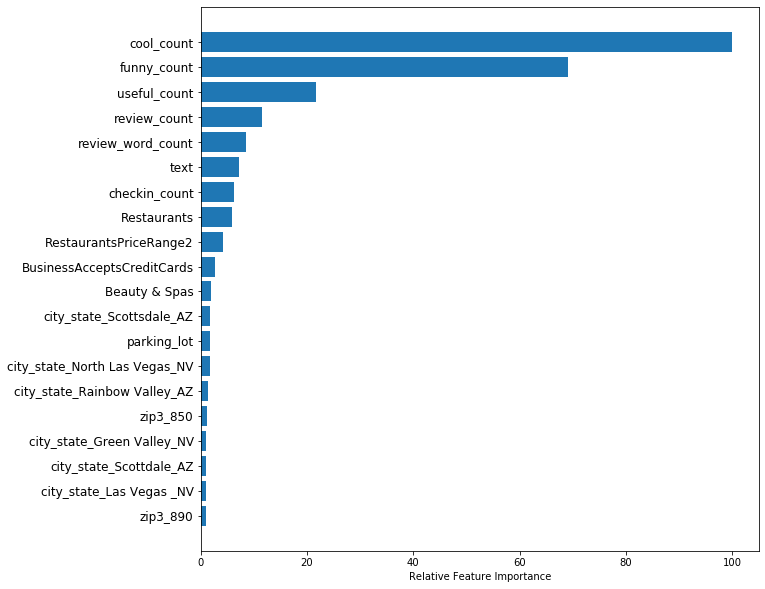

In [12]:
logistic_importance=get_importance(log_lbfgs_model_final)
plot_importance(logistic_importance,top_n=20)

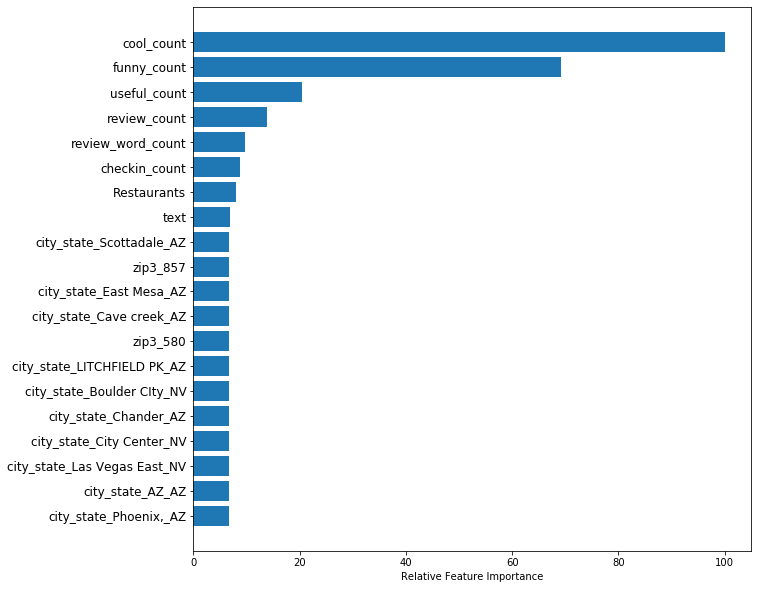

In [13]:
svm_importance=get_importance(svm_sgd_model_final)
plot_importance(svm_importance,top_n=20)

# Interpret Support Vectors	10

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.